<a href="https://colab.research.google.com/github/jorgetapia-ml/sintomas_no_motores_vs_motores_parkinson/blob/develop/Avance5_11Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey
###Prof Grettel Barceló Alonso

## **Avance 5**

###**Modelo final**

* Alejandra Ramírez Romano-A01793144
* Jorge Luis Tapia Peñaloza-A01793013
* Marco Antonio Pérez Castellanos-A01793473



# Introducción

La base de datos está compuesta predominantemente por variables dicotómicas que señalan la presencia o ausencia de un síntoma específico. En modelos anteriores, donde se incorporaron todas las variables seleccionadas, se observó que la agrupación de los datos no era óptima, ya que arrojaban  un coeficiente de Silhouette considerablemente bajo. Para avanzar con el análisis, fue imprescindible explorar y aplicar diferentes enfoques  con el objetivo de obtener información más relevante y precisa. Los siguientes 3 enfoques fueron presentados al  investigador del instituto quien dio su aprobación a las propuestas.  


# Clustering Aglomerativo

El primer abordaje con Clustering Aglomerativo consiste en separar los síntomas en dos grupos:

a) Neuropsiquiátricos (no motores)

b) Motores


El clustering es aplicado a los síntomas Neuropsiquiátricos (no motores), esto con la finalidad de identificar grupos con características similares. Posteriormente, a través de un dendrograma, se determina la cantidad óptima de clusters. Se calcula su coeficiente de Silhouette para indicar la definición de los clusters. Finalmente, se calcula el promedio de los síntomas motores agrupados y se establece una relación con los síntomas neuropsiquiátricos para cada uno de los grupos.

Este primer enfoque permite visualizar y perfilar la relación entre el cluster de variables de síntomas neuropsiquiátricos y el comportamiento de los síntomas motores


# K-means


En el segundo abordaje utilizando el algoritmo K-Means, se busca descubrir patrones comunes en los síntomas neuropsiquiátricos (como problemas de memoria, estado de ánimo y sueño) en pacientes con enfermedad de Parkinson. Además, se pretende entender cómo estos patrones se relacionan con los síntomas motores.

Para este enfoque, se requiere la creación de nuevas características para dar dirección adecuada a la aplicación del modelo. Se inicia sumando varios síntomas neuropsiquiátricos, como claridad mental, estado de ánimo, motivación, apatía, control emocional, problemas de sueño y somnolencia diurna. Esto proporciona una puntuación total de síntomas para cada paciente, lo cual es útil para obtener una visión general del nivel total de problemas neuropsiquiátricos que experimenta cada individuo.

Construimos las siguientes variables:

* 'Total_Symptoms':Definida como la suma de varias caracteristicas con la intención de contar el número de síntomas presentes. Cada columna representa la presencia (1) o ausencia (0) de un síntoma, por lo que la suma proporcionará el número total de síntomas que un individuo presenta. Este tipo de agregación es útil para tener una medida simple y rápida del estado general del paciente en términos de número de síntomas.

* 'Sintomas Sueño':Definida como la interaction (producto) entre las variables que determinan la existencia de problemas que tienen que ver con el sueño.

* 'Sintomas Estado de Animo':Definida como la interaction (producto) entre las variables que determinan la existencia de problemas con los estados de ánimo.

Una vez generadas estas características, se aplica K-Means para dividir a los pacientes en grupos (o “clusters”). Agrupar a los pacientes con síntomas similares ayuda a identificar patrones comunes y posibles subtipos de Parkinson. Finalmente y de forma similar al primer enfoque, se calcula el coeficiente de Silhouette para medir la definición de los clusters obtenidos.

 # Modelo Supervisado combinado con clusterización

 Este tercer enfoque plantea abordar el problema de la segmentación mediante un modelo supervisado. Esta estrategia  permite aplicar técnicas de explicabilidad, lo que proporciona información sobre cómo cada síntoma no motor influye en los síntomas motores. Además, es posible realizar una segmentación que resuma el comportamiento de los síntomas motores y, a partir de esto, generar un modelo de clasificación.

Las variables son las siguientes:

1. Variable Objetivo (Y): Representa el “Total de Síntomas Motores” dividido por la “Segmentación por cluster”. Esta variable  permite evaluar la relación entre los síntomas motores y la agrupación de pacientes.


2. Variables Independientes (X): Se refiere a la “Matriz de síntomas neuropsiquiátricos”. Estas características incluyen los síntomas no motores y proporcionan información relevante para el análisis.

Modelos como la regresión logística, árboles de decisión o bosques aleatorios, permiten comprender cómo las variables independientes afectan a la variable objetivo. Aunado a esto, se emplean técnicas de explicabilidad, como shape values o LIME, para comprender mejor las relaciones y patrones en los datos. Estas herramientas ayudan a identificar qué características son más influyentes en la predicción de los síntomas motores.


En resumen, aunque no existe un punto de comparación común entre los tres modelos, cada propuesta proporciona información relevante para la investigación.


In [ ]:
!pip install -q scikit-learn-extra kmodes shap

#**Librerias y carga de datos**

---

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import classification_report
from PIL import Image
from matplotlib.table import Table
from datetime import datetime
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from itertools import chain
import warnings
import shap
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/data/parkinson_ai.csv"
#file_path = "parkinson_ai.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    data = pd.read_csv(file_path, sep="|")
except Exception as e:
    print("Error al cargar el archivo:", e)

In [ ]:
motor_cols = ['Presencia de temblor', 'Dificultades para levantarse',
              'Problemas con marcha y equilibrio', 'Congelación al caminar',
              'Lenguaje', 'Expresión facial', 'Rigidez - Cuello', 'Rigidez - MSD',
              'Rigidez - MSI', 'Rigidez - MID', 'Rigidez - MII']


In [ ]:
#Definir un diccionario llamado updrs que contiene tres claves: “UPDRS1”, “UPDRS2” y “UPDRS3”.
updrs = {"UPDRS1": ["Estado mental (p. ej., claridad, atención y memoria).",
                    'Alucinaciones y psicosis.',
                    'Estado de ánimo depresivo.', 'Estado de ánimo ansioso.', "Apatia",
                    "Control de emocional", "Problema de sueño", "Somnolencia diurna"],
          "UPDRS2": ["Problemas para hablar", "Exceso de saliva", "Dificultades para tragar y comer", "Manejo de alimentos y cubiertos complicado",
                      "Problemas para vestirse", "Ayuda necesaria en higiene personal", "Dificultad en la escritura", "Problemas para realizar hobbies",
                      "Dificultades para moverse en la cama", "Presencia de temblor", "Dificultades para levantarse", "Problemas con marcha y equilibrio", "Congelación al caminar"],
          "UPDRS3": ["Lenguaje", "Expresión facial", "Rigidez - Cuello", "Rigidez - MSD", "Rigidez - MSI", "Rigidez - MID", "Rigidez - MII", "Golpeteo de dedos (tapping) - Mano derecha",
                     "Golpeteo de dedos (tapping) - Mano izquierda", "Movimientos de las manos - Mano derecha", "Movimientos de las manos - Mano izquierda", "Pronación-supinación - Mano derecha",
                     "Pronación-supinación - Mano izquierda", "Golpeteo con los dedos de los pies - Pie derecho", "Golpeteo con los dedos de los pies - Pie izquierdo",
                     "Agilidad con las piernas - Pierna derecha", "Agilidad con las piernas - Pierna izquierda", "Levantarse de la silla", "Marcha", "Congelación de la marcha", "Estabilidad postural",
                     "Postura", "Espontaneidad global de movimientos", "Temblor postural - Mano derecha", "Temblor postural - Mano izquierda",
                     "Temblor de acción - Mano derecha", "Temblor de acción - Mano izquierda", "Amplitud del temblor de reposo - MSD", "Amplitud del temblor de reposo - MSI",
                     "Amplitud del temblor de reposo - MID", "Amplitud del temblor de reposo - MII", "Amplitud del temblor de reposo - Labio/mandíbula", "Persistencia del temblor de reposo"]
                }

In [ ]:
d = {'Estado mental (p. ej., claridad, atención y memoria).':'Deterioro cognitivo',
 'Estado de ánimo y comportamiento (p. ej., depresión, motivación).': 'Alucinaciones y psicosis.',
 'Actividad del día a día y comportamiento.': 'Estado de ánimo depresivo.',
 'Motivación/Iniciativa.': 'Estado de ánimo ansioso.'}

In [ ]:
data.rename(columns = d, inplace = True)

In [ ]:
# Filtrar el diccionario updrs para mantener solo aquellos elementos cuyos valores están presentes en las columnas del DataFrame data
updrs = {k: [filter_v for filter_v in v if filter_v in data.columns] for k,v in updrs.items()}

In [ ]:
# Aplanar las listas de valores en el diccionario updrs en una sola lista
all_updrs = list(chain.from_iterable(updrs.values()))

In [ ]:
data[all_updrs] = data[all_updrs].fillna(0)

In [ ]:
# Eliminar cualquier fila en el DataFrame data que tenga algún valor nulo (NaN) en las columnas especificadas en all_updrs
data.dropna(subset = all_updrs, how="any", inplace=True)

In [ ]:
# Devolver la forma del DataFrame data después de eliminar las filas con valores nulos
data.shape

(235, 78)

In [ ]:
neuropsychiatric_cols = ['Estado mental (p. ej., claridad, atención y memoria).',
                         'Alucinaciones y psicosis.',
                         'Estado de ánimo depresivo.',
                         'Estado de ánimo ansioso.',
                         'Apatia',
                         'Control de emocional',
                         'Problema de sueño',
                         'Somnolencia diurna']

motor_cols = ['Presencia de temblor', 'Dificultades para levantarse',
              'Problemas con marcha y equilibrio', 'Congelación al caminar',
              'Lenguaje', 'Expresión facial', 'Rigidez - Cuello', 'Rigidez - MSD',
              'Rigidez - MSI', 'Rigidez - MID', 'Rigidez - MII']

neuropsychiatric_cols = updrs["UPDRS1"]
motor_cols = updrs["UPDRS2"] + updrs["UPDRS3"]
complementary_cols=['IMC','MOCA','Hoehn y Yahr','MDS-UPDRS']

In [ ]:
neuropsychiatric_cols

['Alucinaciones y psicosis.',
 'Estado de ánimo depresivo.',
 'Estado de ánimo ansioso.',
 'Apatia',
 'Control de emocional',
 'Problema de sueño',
 'Somnolencia diurna']

# Creacion familias

Se presenta un análisis comparativo de los clusters basados en síntomas motores de la enfermedad de Parkinson. Las familias se distinguen por la duración de la enfermedad: Familia 1 (desconocido), Familia 2 (2-10 años), y Familia 3 (más de 11 años).

In [ ]:
data["a_enf_con_edad"] = data["Edad Actual"] - data["Edad de diagnostico"].fillna(data["Edad Actual"])

In [ ]:
data["family"] = pd.qcut(data["a_enf_con_edad"], q=3).rank(method="dense")

In [ ]:
data.dropna(subset=["family"], inplace=True)

In [ ]:
pd.qcut(data["a_enf_con_edad"], q=3).unique()

[(11.0, 29.0], (2.0, 11.0], (-0.001, 2.0]]
Categories (3, interval[float64, right]): [(-0.001, 2.0] < (2.0, 11.0] < (11.0, 29.0]]

In [ ]:
data["family"].unique()

array([3., 2., 1.])

In [ ]:
data.shape

(220, 80)

In [ ]:
# Crear una copia del DataFrame data que contiene solo las columnas especificadas en all_updrs
X = data.copy()

#**Enfoque 1: Clustering Aglomerativo**

In [ ]:
X_to_cluster_nom = X[["family"] + neuropsychiatric_cols].copy()

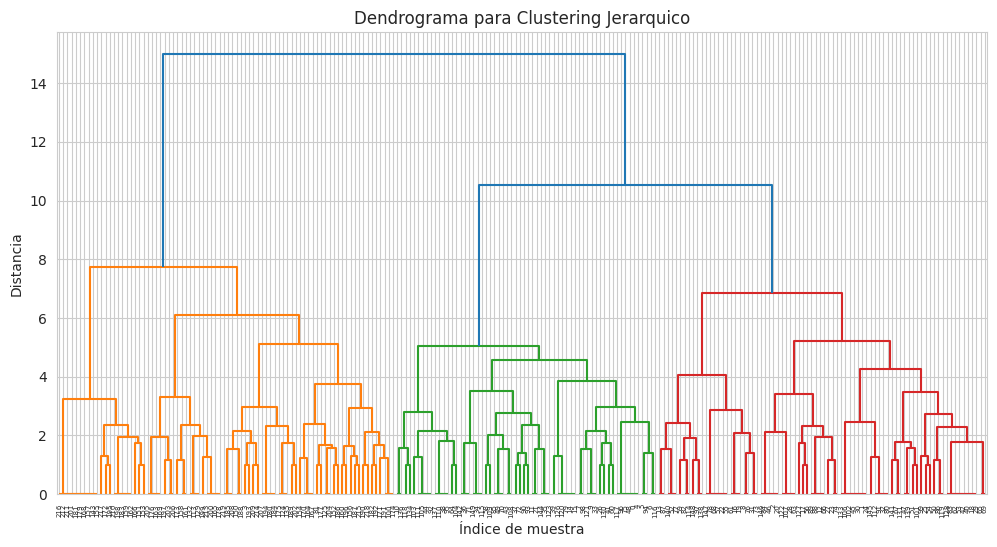

In [ ]:
# Generar el linkage matrix para el dendrograma
Z = linkage(X_to_cluster_nom, method='ward')

# Dibujar el dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Dendrograma para Clustering Jerarquico')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
plt.show()

El gráfico sugiere dos clusters como óptimos para las variables no motoras

In [ ]:
# Crear un pipeline de preprocesamiento que primero estandariza los datos y luego aplica PCA con 2 componentes
n_components = X_to_cluster_nom.shape[1]-1
n_components = 2
pipeline_pc = Pipeline(steps=[("standard", StandardScaler()), ("pca", PCA(n_components=n_components))])
X_pca_nom = pd.DataFrame(pipeline_pc.fit_transform(X_to_cluster_nom[neuropsychiatric_cols]), columns=[f"p_{i}" for i in range(n_components)], index=X_to_cluster_nom.index)
X_pca_nom["family"] = X_to_cluster_nom["family"]

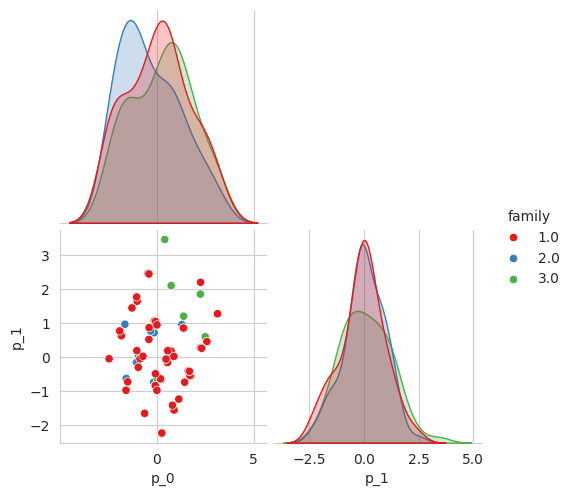

In [ ]:
#Generar un grafico de pares
sns.pairplot(X_pca_nom, hue="family", corner=True, palette="Set1");

Num Clusters: 2, Silhouette Score: 0.22
Num Clusters: 3, Silhouette Score: 0.19
Num Clusters: 4, Silhouette Score: 0.17
Num Clusters: 5, Silhouette Score: 0.17
Num Clusters: 6, Silhouette Score: 0.18
Num Clusters: 7, Silhouette Score: 0.18
Num Clusters: 8, Silhouette Score: 0.19
Num Clusters: 9, Silhouette Score: 0.19
Num Clusters: 10, Silhouette Score: 0.20


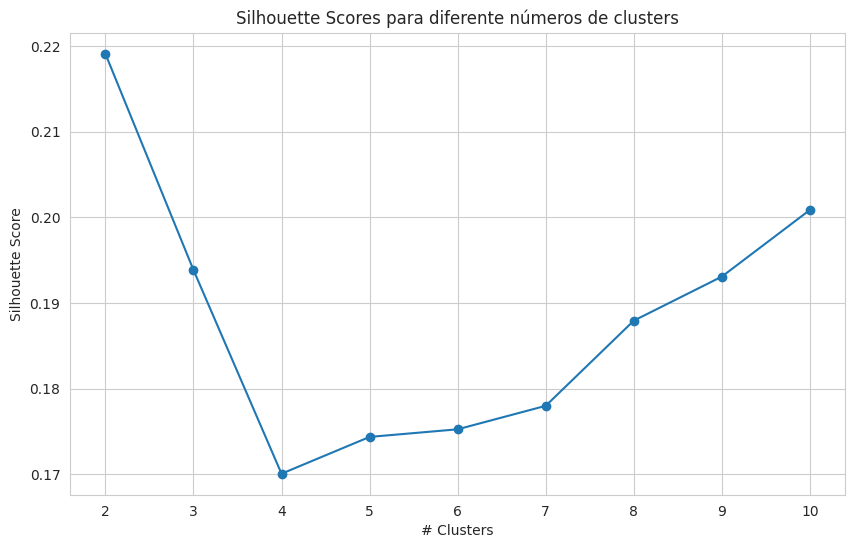

In [ ]:
# Función para evaluar diferentes números de clusters
def evaluate_clusters(data, min_clusters=2, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(min_clusters, max_clusters + 1):
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        clusters = agg_clustering.fit_predict(data)
        if len(np.unique(clusters)) > 1:  # Asegurarse de que no hay solo un cluster
            silhouette_avg = silhouette_score(data, clusters)
            silhouette_scores.append(silhouette_avg)
            print(f'Num Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}')
        else:
            silhouette_scores.append(-1)  # Indicador de un solo cluster
            print(f'Num Clusters: {n_clusters}, Silhouette Score: Error (Cluster único)')
    return silhouette_scores

# Evaluar diferentes números de clusters
silhouette_scores = evaluate_clusters(X_to_cluster_nom, min_clusters=2, max_clusters=10)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferente números de clusters')
plt.show()

Este gráfico confirma que el mejor score de Silhouette ocurre con dos clusters. El score es bajo lo cual sugiere que no existe una óptima definición de clusters incluso después de agregar la variable de “Family”

In [ ]:
# Aplicar Agglomerative Clustering con el número de clusters decidido
k = 2
agg_clustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
clusters = agg_clustering.fit_predict(X_to_cluster_nom)

In [ ]:
motor_data = X[["family"] + motor_cols].copy()

<Axes: ylabel='Cluster'>

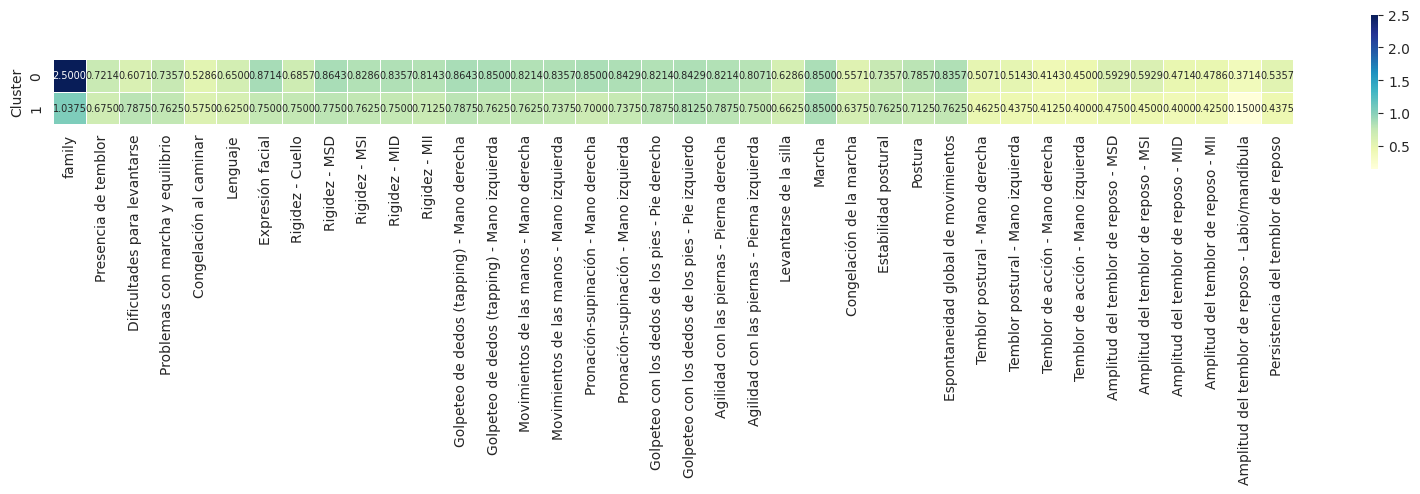

In [ ]:
# Relacionar clusters con síntomas motores (agregar clusters a los datos de síntomas motores)
motor_data['Cluster'] = clusters
X_to_cluster_nom['Cluster'] = clusters

cluster_means_moto = motor_data.groupby('Cluster').mean()

fig, ax= plt.subplots(figsize=(20, 20))
ax.set_aspect('equal','box')
sns.heatmap(cluster_means_moto, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})

#Perfilamiento
En este gráfico se observan dos clusters:

#Cluster 0
**Variable 1 (Family)**: En este cluster es donde se encuentran los pacientes con mayor cantidad de años con la enfermedad.

**Variable 8 (Rigidez MSD) al 22 ( Agilidad con las piernas)**: Prevalecen los sintomas no motores.

Lo anterior ayuda a concluir que el Cluster 0 incluye a aquellos pacientes con más sintomas no motores y con mayor cantidad de años con la enfermedad.

#Cluster 1

**Variable 1 (Family)**: En este cluster es donde se encuentran los pacientes con meno cantidad de años con la enfermedad

Por otro lado , el cluster 1 agrupa a aquellos pacientes con menor prevalencia de sintomas no motores y con menor cantidad de años con la enfermedad.

Se puede notar que la marcha es un sintoma compartido en ambos clusters.


<Axes: ylabel='Cluster'>

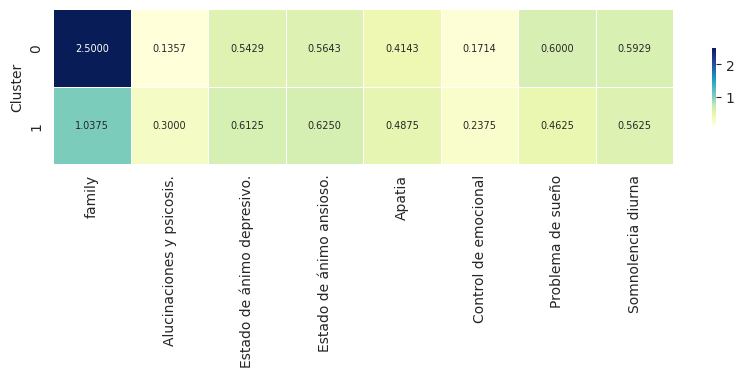

In [ ]:
cluster_means_neuro = X_to_cluster_nom.groupby('Cluster').mean()

fig, ax= plt.subplots(figsize=(10, 10))
ax.set_aspect('equal','box')
sns.heatmap(cluster_means_neuro, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})

En este gráfico se resalta que el problema del sueño y somnolencia diurna es mayor para pacientes con mayor prevalencia de sintomas no motores y con mayor cantidad de años con la enfermedad.

# Clustering Aglomerativo ( En busca de clusters de variables motoras)

In [ ]:
X_to_cluster_m = X[["family"] + motor_cols].copy()

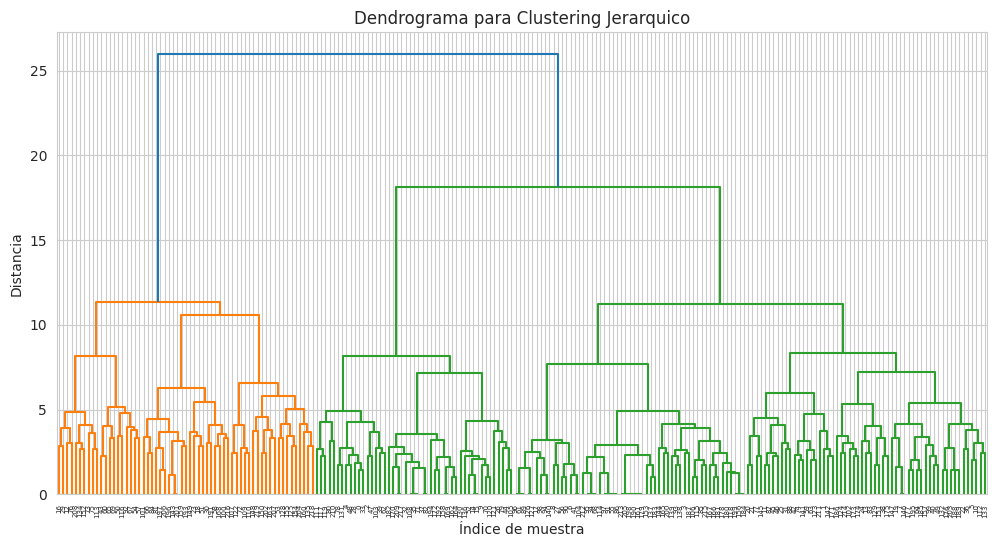

In [ ]:
# Generar el linkage matrix para el dendrograma
Z = linkage(X_to_cluster_m, method='ward')

# Dibujar el dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Dendrograma para Clustering Jerarquico')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
plt.show()

De igual forma el gráfico sugiere dos clusters como óptimos para las variables  motoras

In [ ]:
# Crear un pipeline de preprocesamiento que primero estandariza los datos y luego aplica PCA con 2 componentes
n_components = X_to_cluster_m.shape[1]-1
n_components = 2
pipeline_pc = Pipeline(steps=[("standard", StandardScaler()), ("pca", PCA(n_components=n_components))])
X_pca_m = pd.DataFrame(pipeline_pc.fit_transform(X_to_cluster_m[motor_cols]), columns=[f"p_{i}" for i in range(n_components)], index=X_to_cluster_m.index)
X_pca_m["family"] = X_to_cluster_m["family"]

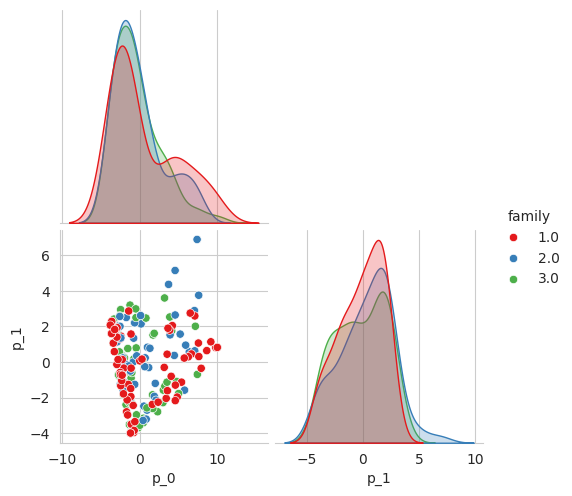

In [ ]:
#Generar un grafico de pares
sns.pairplot(X_pca_m, hue="family", corner=True, palette="Set1");

Num Clusters: 2, Silhouette Score: 0.25
Num Clusters: 3, Silhouette Score: 0.15
Num Clusters: 4, Silhouette Score: 0.16
Num Clusters: 5, Silhouette Score: 0.12
Num Clusters: 6, Silhouette Score: 0.13
Num Clusters: 7, Silhouette Score: 0.12
Num Clusters: 8, Silhouette Score: 0.13
Num Clusters: 9, Silhouette Score: 0.13
Num Clusters: 10, Silhouette Score: 0.09


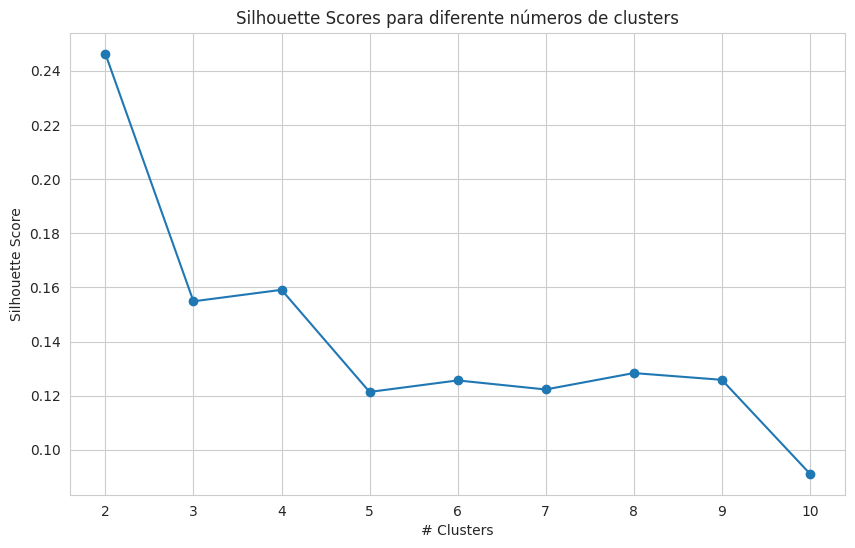

In [ ]:
# Función para evaluar diferentes números de clusters
def evaluate_clusters(data, min_clusters=2, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(min_clusters, max_clusters + 1):
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        clusters = agg_clustering.fit_predict(data)
        if len(np.unique(clusters)) > 1:  # Asegurarse de que no hay solo un cluster
            silhouette_avg = silhouette_score(data, clusters)
            silhouette_scores.append(silhouette_avg)
            print(f'Num Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}')
        else:
            silhouette_scores.append(-1)  # Indicador de un solo cluster
            print(f'Num Clusters: {n_clusters}, Silhouette Score: Error (Cluster único)')
    return silhouette_scores

# Evaluar diferentes números de clusters
silhouette_scores = evaluate_clusters(X_to_cluster_m, min_clusters=2, max_clusters=10)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferente números de clusters')
plt.show()

Este gráfico confirma que el mejor score de Silhouette ocurre con dos clusters. El score es bajo lo cual sugiere que no existe una óptima definición de clusters incluso después de agregar la variable de “Family” y de hacer un cambio de enfoque al intentar clusterizar las variables motoras.

In [ ]:
# Aplicar Agglomerative Clustering con el número de clusters decidido
k = 2
agg_clustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
clusters = agg_clustering.fit_predict(X_to_cluster_m)

<Axes: ylabel='Cluster'>

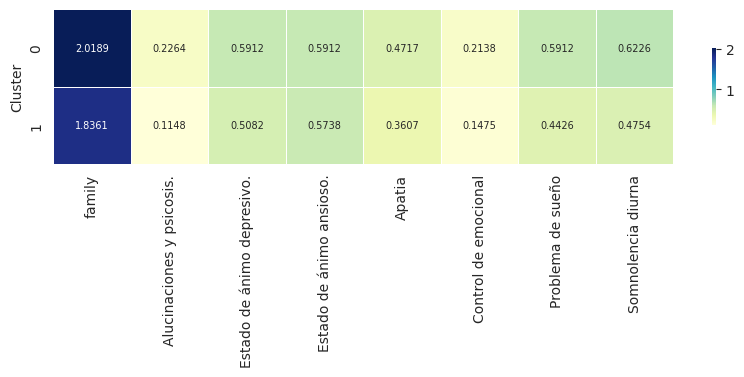

In [ ]:
# Relacionar clusters con síntomas motores (agregar clusters a los datos de síntomas motores)
X_to_cluster_nom['Cluster'] = clusters
X_to_cluster_m['Cluster'] = clusters

cluster_means_nomoto = X_to_cluster_nom.groupby('Cluster').mean()

fig, ax= plt.subplots(figsize=(10, 10))
ax.set_aspect('equal','box')
sns.heatmap(cluster_means_nomoto, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})

De nueva cuenta en este gráfico se resalta que el problema del sueño y somnolencia diurna es mayor para pacientes con mayor cantidad de años con la enfermedad.

<Axes: ylabel='Cluster'>

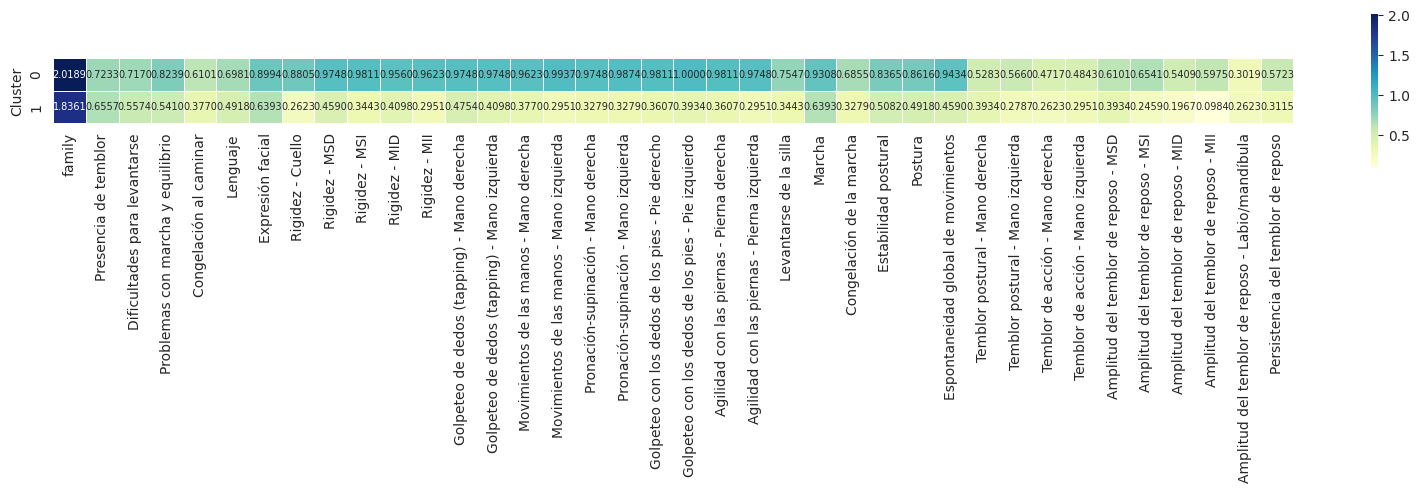

In [ ]:
cluster_means_moto = X_to_cluster_m.groupby('Cluster').mean()

fig, ax= plt.subplots(figsize=(20, 20))
ax.set_aspect('equal','box')
sns.heatmap(cluster_means_moto, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})

De igual forma, se observan dos clusters donde uno de ellos (Cluster 0) es el que reporta una prevalencia de sintomas motores.

#**Enfoque 2:  K-Means**

---



In [ ]:
# Selección de columnas relevantes
neuropsychiatric_columns = [
    'Deterioro cognitivo',
    'Alucinaciones y psicosis.',
    'Estado de ánimo depresivo.',
    'Estado de ánimo ansioso.',
    'Apatia',
    'Control de emocional',
    'Problema de sueño',
    'Somnolencia diurna'
]

motor_columns = [
    'Presencia de temblor',
    'Dificultades para levantarse',
    'Problemas con marcha y equilibrio',
    'Congelación al caminar',
    'Lenguaje',
    'Expresión facial',
    'Rigidez - Cuello',
    'Rigidez - MSD',
    'Rigidez - MSI',
    'Rigidez - MID',
    'Rigidez - MII',
    'Golpeteo de dedos (tapping) - Mano derecha',
    'Golpeteo de dedos (tapping) - Mano izquierda',
    'Movimientos de las manos - Mano derecha',
    'Movimientos de las manos - Mano izquierda',
    'Pronación-supinación - Mano derecha',
    'Pronación-supinación - Mano izquierda',
    'Golpeteo con los dedos de los pies - Pie derecho',
    'Golpeteo con los dedos de los pies - Pie izquierdo',
    'Agilidad con las piernas - Pierna derecha',
    'Agilidad con las piernas - Pierna izquierda',
    'Levantarse de la silla',
    'Marcha',
    'Congelación de la marcha',
    'Estabilidad postural',
    'Postura',
    'Espontaneidad global de movimientos',
    'Temblor postural - Mano derecha',
    'Temblor postural - Mano izquierda',
    'Temblor de acción - Mano derecha',
    'Temblor de acción - Mano izquierda',
    'Amplitud del temblor de reposo - MSD',
    'Amplitud del temblor de reposo - MSI',
    'Amplitud del temblor de reposo - MID',
    'Amplitud del temblor de reposo - MII',
    'Amplitud del temblor de reposo - Labio/mandíbula',
    'Persistencia del temblor de reposo'
]

# Extraer datos relevantes
neuropsychiatric_data = data[neuropsychiatric_columns]
motor_data = data[motor_columns]

#Caracteristicas adicionales.

Con el afán de poder obtener mejores rendimientos con las técnicas de clusterización adicionamos variables que recojan en manera más amplia la información de las variables involucradas.

Construimos las siguientes variables:

1. 'Total_Symptoms':Definida como la suma de varias caracteristicas con la intención de contar el número de síntomas presentes. Cada columna representa la presencia (1) o ausencia (0) de un síntoma, por lo que la suma proporcionará el número total de síntomas que un individuo presenta. Este tipo de agregación es útil para tener una medida simple y rápida del estado general del paciente en términos de número de síntomas.

2. 'Sintomas Sueño':Definida como la interaction (producto) entre las variables que determinan la existencia de problemas que tienen que ver con el sueño.

3. 'Sintomas Estado de Animo':Definida como la interaction (producto) entre las variables que determinan la existencia de problemas con los estados de ánimo.

Construir estas variables adicionales podría ser relevante para identificar subgrupos de pacientes con una combinación particular de síntomas que afectan su tratamiento o pronóstico.

In [ ]:
# Crear características agregadas
neuropsychiatric_data['Total_Symptoms'] = neuropsychiatric_data[
    [
    'Deterioro cognitivo',
    'Alucinaciones y psicosis.',
    'Estado de ánimo depresivo.',
    'Estado de ánimo ansioso.',
    'Apatia',
    'Control de emocional',
    'Problema de sueño',
    'Somnolencia diurna'
    ]
].sum(axis=1)


neuropsychiatric_data['Sintomas_Sueño'] = neuropsychiatric_data['Problema de sueño'] * neuropsychiatric_data['Somnolencia diurna']
neuropsychiatric_data['Sintomas_Estado_Animo'] = neuropsychiatric_data['Estado de ánimo depresivo.'] * neuropsychiatric_data['Estado de ánimo ansioso.']* neuropsychiatric_data['Apatia']
neuropsychiatric_data['Sintomas_Otros'] =neuropsychiatric_data['Deterioro cognitivo'] * neuropsychiatric_data['Control de emocional']

# Normalizar los datos
scaler = StandardScaler()
neuropsychiatric_data_scaled = scaler.fit_transform(neuropsychiatric_data)

# Seleccionar características nuevas y originales para la clusterización
features_for_clustering = neuropsychiatric_data[
    [
        'Total_Symptoms',
        'Sintomas_Sueño',
        'Sintomas_Estado_Animo'
    ]
]

# Normalizar las nuevas características
features_for_clustering_scaled = scaler.fit_transform(features_for_clustering)


##Clusterización Utilizando K-means


Es cierto que no es común e incluso recomendado usar la técnica de K-means en datos binarios , sin embargo encontramos en la literatura algunas aplicaciones interesantes , además de que las contrucción de las variables anteriores hará más sentido.

In [ ]:
# Aplicar K-means con 3 clusters a las nuevas características
kmeans_new = KMeans(n_clusters=3, random_state=0)
clusters_new = kmeans_new.fit_predict(features_for_clustering_scaled)

# Calcular el índice de silueta para los nuevos clusters
silhouette_avg_new = silhouette_score(features_for_clustering_scaled, clusters_new)

# Añadir los nuevos clusters a los datos originales
neuropsychiatric_data['Cluster_New'] = clusters_new

# Agrupar por clusters y calcular las medias para ver las características de cada cluster
cluster_summary_new = neuropsychiatric_data.groupby('Cluster_New').mean()

# Redondear el puntaje de Silhouette a 4 dígitos
silhouette_avg_rounded = round(silhouette_avg_new, 4)

# Imprimir el puntaje de Silhouette
print(f'Silhouette Score es: {silhouette_avg_rounded}')

cluster_summary_new

Silhouette Score es: 0.6232


,Deterioro cognitivo,Alucinaciones y psicosis.,Estado de ánimo depresivo.,Estado de ánimo ansioso.,Apatia,Control de emocional,Problema de sueño,Somnolencia diurna,Total_Symptoms,Sintomas_Sueño,Sintomas_Estado_Animo,Sintomas_Otros
Cluster_New,,,,,,,,,,,,
0,0.391304,0.152174,0.586957,0.456522,0.260870,0.195652,1.000000,1.000000,4.043478,1.000000,0.0,0.108696
1,0.320388,0.077670,0.281553,0.378641,0.116505,0.106796,0.300971,0.310680,1.893204,0.000000,0.0,0.038835
2,0.577465,0.380282,1.000000,1.000000,1.000000,0.338028,0.661972,0.746479,5.704225,0.521127,1.0,0.253521


Dado que usamos variables agregadas preferimos utilizar los componentes principales para visualizar la diferencia en los grupos a través de sus componentes principales. Usar PCA para graficar los clusters tiene las siguientes ventajas:

- Permite reducir la dimensionalidad para facilitar la visualización.
- Captura la mayor parte de la variabilidad importante de los datos.
- Mejora la separación visual de clusters.
- Reduce el ruido y la redundancia, destacando las estructuras significativas.

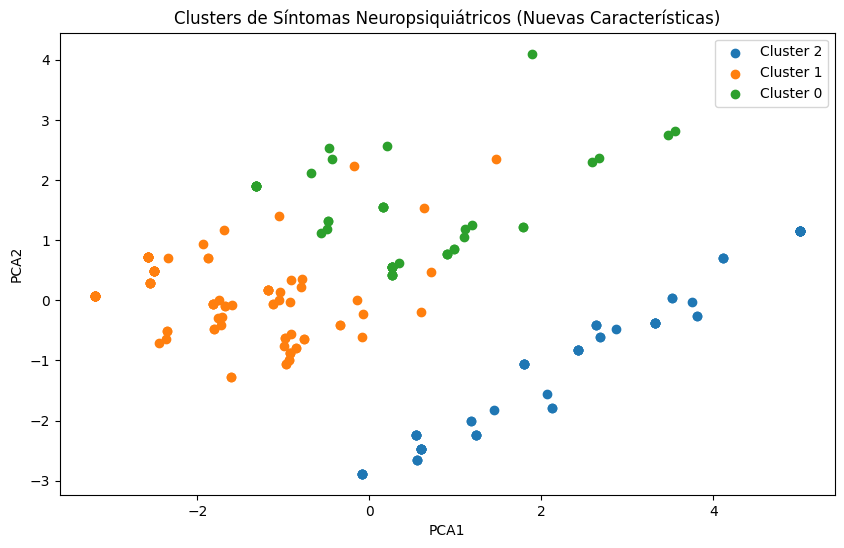

In [ ]:
# Aplicar PCA para crear componentes principales
pca = PCA(n_components=2)
pca_features = pca.fit_transform(neuropsychiatric_data_scaled)
neuropsychiatric_data['PCA1'] = pca_features[:, 0]
neuropsychiatric_data['PCA2'] = pca_features[:, 1]

# Graficar los clusters usando las nuevas características PCA
plt.figure(figsize=(10, 6))
for cluster in neuropsychiatric_data['Cluster_New'].unique():
    subset = neuropsychiatric_data[neuropsychiatric_data['Cluster_New'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters de Síntomas Neuropsiquiátricos (Nuevas Características)')
plt.legend()
plt.show()

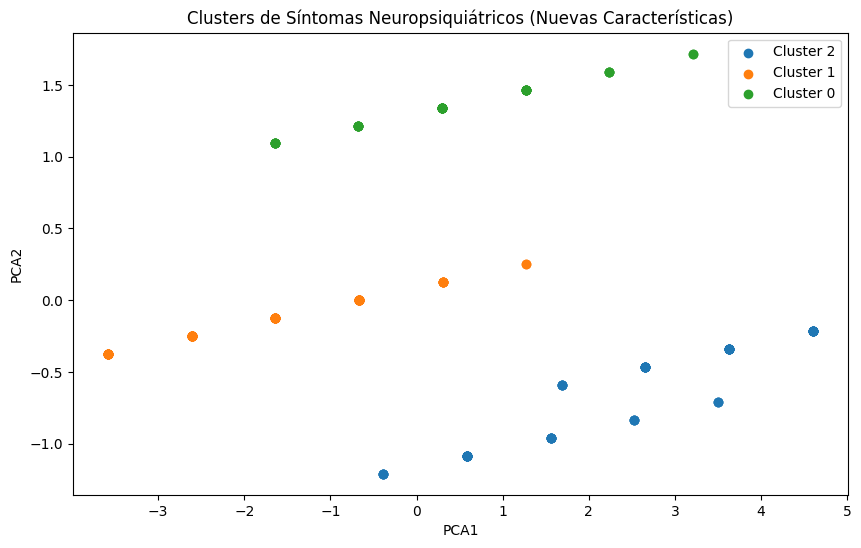

In [ ]:
features_for_clustering['Cluster_New'] = clusters_new
# Aplicar PCA para crear componentes principales
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_for_clustering )
features_for_clustering['PCA1'] = pca_features[:, 0]
features_for_clustering['PCA2'] = pca_features[:, 1]

# Graficar los clusters usando las nuevas características PCA
plt.figure(figsize=(10, 6))
for cluster in features_for_clustering['Cluster_New'].unique():
    subset = features_for_clustering[features_for_clustering['Cluster_New'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters de Síntomas Neuropsiquiátricos (Nuevas Características)')
plt.legend()
plt.show()

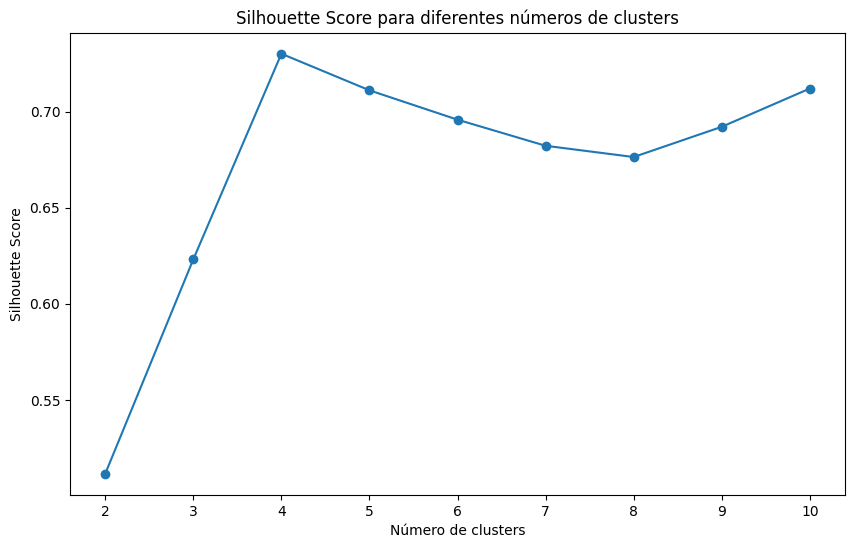

4

In [ ]:
# Probar diferentes números de clusters para encontrar el número óptimo basado en el Silhouette Score
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(features_for_clustering_scaled)
    score = silhouette_score(features_for_clustering_scaled, clusters)
    silhouette_scores.append(score)

# Graficar el Silhouette Score para diferentes números de clusters
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes números de clusters')
plt.show()

# Encontrar el número óptimo de clusters
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
optimal_k

A partir de este score, se observa que el número optimo de clusters es de 4

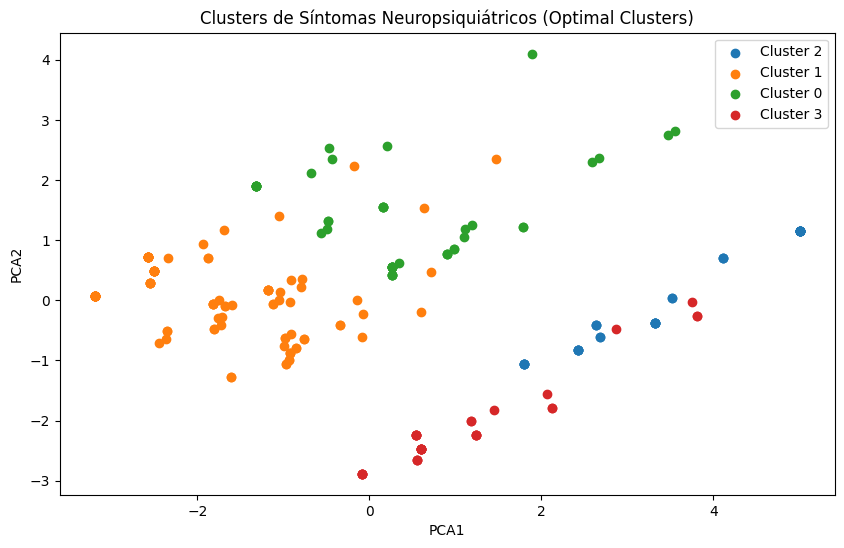

,Deterioro cognitivo,Alucinaciones y psicosis.,Estado de ánimo depresivo.,Estado de ánimo ansioso.,Apatia,Control de emocional,Problema de sueño,Somnolencia diurna,Total_Symptoms,Sintomas_Sueño,Sintomas_Estado_Animo,Sintomas_Otros,Cluster_New,PCA1,PCA2,Cluster
Cluster_Optimal,,,,,,,,,,,,,,,,
0,0.391304,0.152174,0.586957,0.456522,0.260870,0.195652,1.000000,1.000000,4.043478,1.0,0.0,0.108696,0.0,0.372658,1.401881,0.0
1,0.320388,0.077670,0.281553,0.378641,0.116505,0.106796,0.300971,0.310680,1.893204,0.0,0.0,0.038835,1.0,-1.779567,0.063811,1.0
2,0.675676,0.567568,1.000000,1.000000,1.000000,0.513514,1.000000,1.000000,6.756757,1.0,1.0,0.378378,2.0,3.477834,0.020758,2.0
3,0.470588,0.176471,1.000000,1.000000,1.000000,0.147059,0.294118,0.470588,4.558824,0.0,1.0,0.117647,2.0,1.102155,-2.112561,3.0


In [ ]:
# Aplicar K-means con 4 clusters a las nuevas características
k=4
kmeans_optimal = KMeans(n_clusters=4, random_state=0)
clusters_optimal = kmeans_optimal.fit_predict(features_for_clustering_scaled)

# Calcular el índice de silueta para los clusters óptimos
silhouette_avg_optimal = silhouette_score(features_for_clustering_scaled, clusters_optimal)

# Añadir los clusters óptimos a los datos originales
neuropsychiatric_data['Cluster_Optimal'] = clusters_optimal

# Agrupar por clusters y calcular las medias para ver las características de cada cluster
cluster_summary_optimal = neuropsychiatric_data.groupby('Cluster_Optimal').mean()

# Graficar los clusters óptimos usando PCA
plt.figure(figsize=(10, 6))
for cluster in neuropsychiatric_data['Cluster_Optimal'].unique():
    subset = neuropsychiatric_data[neuropsychiatric_data['Cluster_Optimal'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters de Síntomas Neuropsiquiátricos (Optimal Clusters)')
plt.legend()
plt.show()

silhouette_avg_optimal
cluster_summary_optimal


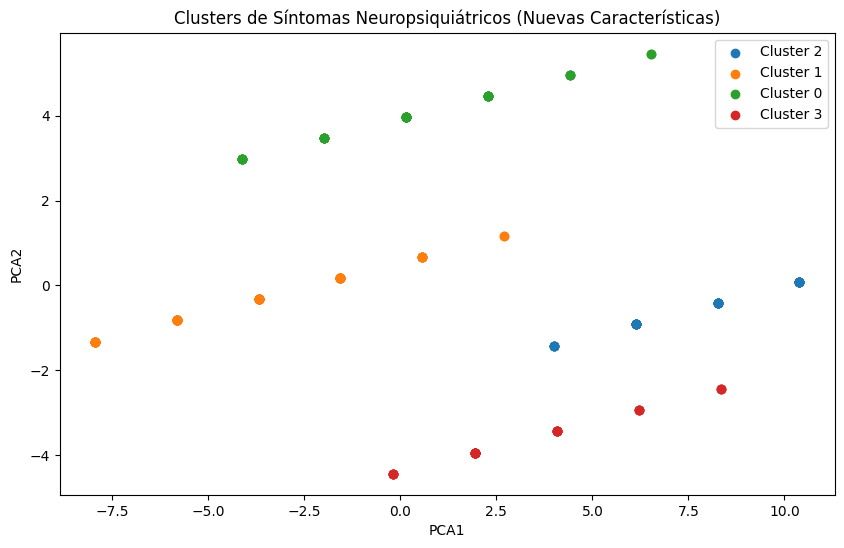

,Deterioro cognitivo,Alucinaciones y psicosis.,Estado de ánimo depresivo.,Estado de ánimo ansioso.,Apatia,Control de emocional,Problema de sueño,Somnolencia diurna,Total_Symptoms,Sintomas_Sueño,Sintomas_Estado_Animo,Sintomas_Otros,Cluster_New,PCA1,PCA2,Cluster
Cluster_Optimal,,,,,,,,,,,,,,,,
0,0.391304,0.152174,0.586957,0.456522,0.260870,0.195652,1.000000,1.000000,4.043478,1.0,0.0,0.108696,0.0,0.372658,1.401881,0.0
1,0.320388,0.077670,0.281553,0.378641,0.116505,0.106796,0.300971,0.310680,1.893204,0.0,0.0,0.038835,1.0,-1.779567,0.063811,1.0
2,0.675676,0.567568,1.000000,1.000000,1.000000,0.513514,1.000000,1.000000,6.756757,1.0,1.0,0.378378,2.0,3.477834,0.020758,2.0
3,0.470588,0.176471,1.000000,1.000000,1.000000,0.147059,0.294118,0.470588,4.558824,0.0,1.0,0.117647,2.0,1.102155,-2.112561,3.0


In [ ]:
# Aplicar K-means con 2 clusters a las nuevas características
k=4
kmeans_optimal = KMeans(n_clusters=4, random_state=0)
clusters_optimal = kmeans_optimal.fit_predict(features_for_clustering_scaled)

# Calcular el índice de silueta para los clusters óptimos
silhouette_avg_optimal = silhouette_score(features_for_clustering_scaled, clusters_optimal)


# Calcular el índice de silueta para los clusters óptimos
silhouette_avg_optimal = silhouette_score(features_for_clustering_scaled, clusters_optimal)

# Añadir los clusters óptimos a los datos originales
neuropsychiatric_data['Cluster_Optimal'] = clusters_optimal

# Agrupar por clusters y calcular las medias para ver las características de cada cluster
cluster_summary_optimal = neuropsychiatric_data.groupby('Cluster_Optimal').mean()

features_for_clustering['Cluster_Optimal'] = clusters_optimal
# Aplicar PCA para crear componentes principales
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_for_clustering )
features_for_clustering['PCA1'] = pca_features[:, 0]
features_for_clustering['PCA2'] = pca_features[:, 1]

# Graficar los clusters usando las nuevas características PCA
plt.figure(figsize=(10, 6))
for clusters_optimal in features_for_clustering['Cluster_Optimal'].unique():
    subset = features_for_clustering[features_for_clustering['Cluster_Optimal'] == clusters_optimal]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {clusters_optimal}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters de Síntomas Neuropsiquiátricos (Nuevas Características)')
plt.legend()
plt.show()

silhouette_avg_optimal
cluster_summary_optimal

###Evaluación del modelo


In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# Asegúrate de que clusters_optimal es un arreglo 1D
#clusters_optimal = np.array(clusters_optimal).flatten()

# Calcular el coeficiente de silueta
silhouette_avg_optimal = silhouette_score(features_for_clustering_scaled, clusters_optimal)
print(f"Silhouette Coefficient: {silhouette_avg_optimal}")

# Calcular el índice de Davies-Bouldin
davies_bouldin_index = davies_bouldin_score(features_for_clustering_scaled, clusters_optimal)
print(f"Davies-Bouldin Index: {davies_bouldin_index}")

# Calcular el índice de Calinski-Harabasz
calinski_harabasz_index = calinski_harabasz_score(features_for_clustering_scaled, clusters_optimal)
print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")

# Calcular la inercia (WCSS) usando KMeans
kmeans = KMeans(n_clusters=4, random_state=42).fit(features_for_clustering_scaled)
inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")

# Calcular el índice de Dunn
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_cluster_labels = np.unique(labels)

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_cluster_labels:
        for j in unique_cluster_labels:
            if i != j:
                inter_cluster_distances.append(distances[np.ix_(labels == i, labels == j)].min())

        intra_cluster_distances.append(distances[np.ix_(labels == i, labels == i)].max())

    return min(inter_cluster_distances) / max(intra_cluster_distances)

dunn = dunn_index(features_for_clustering_scaled, clusters_optimal)
print(f"Dunn Index: {dunn}")


Silhouette Coefficient: 0.7301552550413967
Davies-Bouldin Index: 0.39479455419974807
Calinski-Harabasz Index: 609.5178499362709
Inertia (WCSS): 69.72671369421009
Dunn Index: 0.8962031127749238


Dados estos resultados, el modelo de clustering parece ser muy bueno. Aquí un resumen de cada métrica y su implicación:

* Coeficiente de Silueta (0.7302): Excelente cohesión y separación.
* Índice de Davies-Bouldin (0.3948): Buena separación y compactación.
* Índice de Calinski-Harabasz (609.518): Alta densidad y buena separación.
* Inercia (69.727): Clusters compactos, aunque este valor es más útil para comparaciones.
* Índice de Dunn (0.8962): Buena separación y compactación.

En conjunto, estos resultados indican que los clusters son bien definidos, con alta cohesión interna y buena separación entre ellos. Esto sugiere que el modelo de clustering está capturando bien la estructura subyacente de los datos.

###Búsqueda de relaciones


A partir de heatmaps queremos explorar posibles patrones de prevalencia en cada cluster tanto de los sintomas motoros y neuropsiquiatricos

<Axes: ylabel='Cluster'>

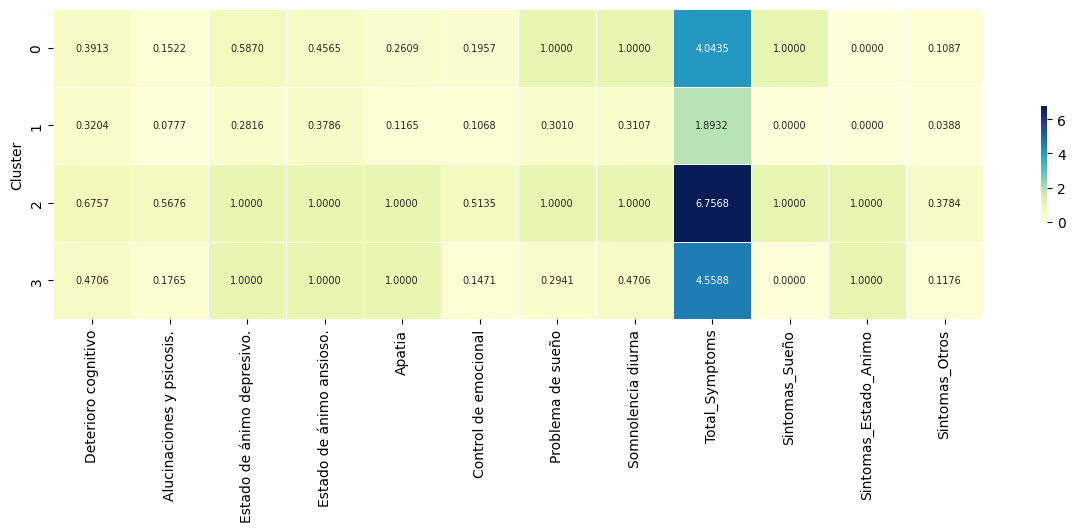

In [ ]:
# Relacionar clusters con síntomas motores (agregar clusters a los datos de síntomas motores)
motor_data['Cluster'] = clusters_optimal
neuropsychiatric_data['Cluster'] = clusters_optimal

cluster_means_neuro = neuropsychiatric_data.groupby('Cluster').mean()
cluster_means_neuro=cluster_means_neuro.drop(['Cluster_Optimal', 'Cluster_New','PCA1','PCA2'], axis=1)

fig, ax= plt.subplots(figsize=(15, 15))
ax.set_aspect('equal','box')
sns.heatmap(cluster_means_neuro, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})

<Axes: ylabel='Cluster'>

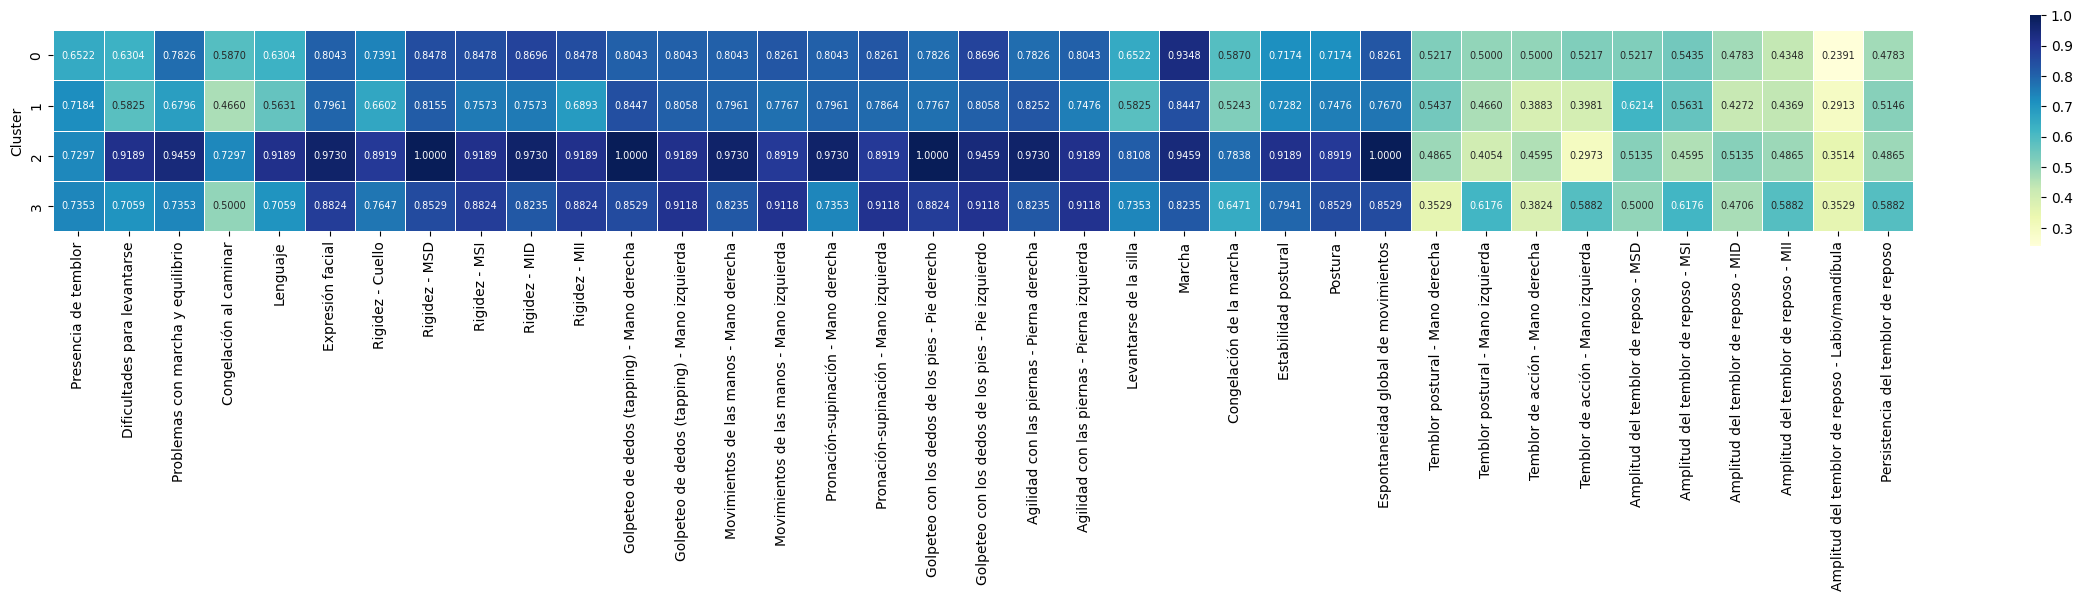

In [ ]:
# Relacionar clusters con síntomas motores (agregar clusters a los datos de síntomas motores)
motor_data['Cluster'] = clusters_optimal
neuropsychiatric_data['Cluster'] = clusters_optimal

cluster_means_motor = motor_data.groupby('Cluster').mean()
#cluster_means_motor=cluster_means_neuro.drop(['Cluster_Optimal', 'Cluster_New'], axis=1)

fig, ax= plt.subplots(figsize=(30, 30))
ax.set_aspect('equal','box')
sns.heatmap(cluster_means_motor, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})

###Caracterización General de Clusters Basada en Síntomas Neuropsiquiátricos y Motores

**Cluster 0**

Este cluster se caracteriza por una alta prevalencia de problemas relacionados con el sueño, con el 100% de los pacientes reportando tanto problemas de sueño como somnolencia diurna. En términos de síntomas neuropsiquiátricos, hay una notable incidencia de síntomas depresivos (58.70%) y ansiosos (45.65%). Motoramente, los pacientes en este cluster también tienen una alta prevalencia de problemas con marcha y equilibrio (78.26%), rigidez (entre 73.91% y 86.96%), y una alta expresión facial afectada (80.43%).


**Cluster 1**

Este es el cluster menos afectado tanto en términos neuropsiquiátricos como motores. Los síntomas depresivos y ansiosos son moderados, con prevalencias del 28.16% y 37.86%, respectivamente. Motoramente, aunque hay una alta prevalencia de temblor (71.84%) y rigidez (entre 66.02% y 81.55%), otros síntomas como dificultades para levantarse y problemas de marcha y equilibrio son menos frecuentes comparados con otros clusters. Los problemas de lenguaje y congelación al caminar también son relativamente menores.

**Cluster 2**

Este es el cluster más afectado en términos generales. Neuropsiquiátricamente, el 100% de los pacientes reportan síntomas depresivos, ansiosos, problemas de sueño y somnolencia diurna. También hay una alta prevalencia de deterioro cognitivo (67.57%) y alucinaciones y psicosis (56.76%). Motoramente, este cluster muestra una alta prevalencia de síntomas en casi todas las áreas, incluyendo problemas de marcha y equilibrio (94.59%), dificultades para levantarse (91.89%), rigidez (casi 100% en varias partes del cuerpo), y una alta afectación en el lenguaje (91.89%) y expresión facial (97.30%).

**Cluster 3**

Este cluster muestra una alta prevalencia de síntomas depresivos y ansiosos (100%), junto con una moderada prevalencia de deterioro cognitivo (47.06%) y alucinaciones y psicosis (17.65%). Motoramente, los pacientes en este cluster tienen una alta prevalencia de rigidez (entre 76.47% y 88.24%) y temblor (73.53%). Problemas de marcha y equilibrio (73.53%) y dificultades para levantarse (70.59%) también son comunes, junto con una notable afectación en la expresión facial (88.24%).

###Comparación de Síntomas Neuropsiquiátricos y Motores por Cluster

**Cluster 0:**

*Neuropsiquiátricos:* Alta prevalencia de problemas de sueño y somnolencia diurna, síntomas depresivos y ansiosos significativos.

*Motores:* Alta prevalencia de problemas de marcha y equilibrio, rigidez, y temblor.

**Cluster 1:**

*Neuropsiquiátricos:* Menor incidencia general de síntomas, con síntomas depresivos y ansiosos moderados.

*Motores:* Alta prevalencia de temblor y rigidez, menores problemas de lenguaje y congelación al caminar.

**Cluster 2:**

*Neuropsiquiátricos:* Alta prevalencia de casi todos los síntomas, el más afectado.

*Motores:* Alta prevalencia en casi todos los síntomas motores, el más afectado en términos de marcha, equilibrio, lenguaje y rigidez.

**Cluster 3:**

*Neuropsiquiátricos:* Alta prevalencia de síntomas depresivos y ansiosos, moderada prevalencia de deterioro cognitivo y alucinaciones.

*Motores:* Alta prevalencia de rigidez y temblor, con menor afectación que el
Cluster 2 en algunos síntomas.


En resumen, podemos observar que los clusters con alta prevalencia de síntomas neuropsiquiátricos también tienden a tener una alta prevalencia de síntomas motores. Cluster 2 es el más afectado en ambos tipos de síntomas, mientras que Cluster 1 tiene la menor afectación general. Cluster 0 y Cluster 3 tienen características mixtas con alta prevalencia de ciertos síntomas en ambos tipos.








###¿Cómo saber si hay efectos particulares entre sintomas y si son más marcados en un cluster que otro?

Para ello usaremos la regresión logistica.La regresión es utilizada para modelar la relación entre una variable dependiente binaria (dicotómica) y una o más variables independientes. Es especialmente útil cuando la variable dependiente puede tomar solo dos valores, como "sí" o "no", "presencia" o "ausencia". Aquí se explican las razones para usar regresión logística para analizar la relación entre síntomas neuropsiquiátricos y síntomas motores:


1. **Modelo de Probabilidad:**
La regresión logística permite modelar la probabilidad de que ocurra un evento, dado un conjunto de variables independientes. En este contexto, el evento es la presencia de un síntoma motor, y las variables independientes son los síntomas neuropsiquiátricos.  

*   Ejemplo:
Queremos saber la probabilidad de que un paciente presente temblor (sí/no) en función de su estado de ánimo (por ejemplo, depresión, motivación). La regresión logística nos ayuda a estimar esta probabilidad.

2. **Relación No Lineal:**
La relación entre la variable dependiente y las variables independientes en la regresión logística es no lineal. Esto es apropiado cuando los cambios en las variables independientes no producen cambios lineales en la variable dependiente.
*  Ejemplo:
Un aumento en la depresión no necesariamente causa un aumento lineal en la probabilidad de tener temblor. En cambio, la relación puede ser más compleja y no lineal.

3. **Interpretación de Coeficientes:**
Los coeficientes en la regresión logística pueden interpretarse en términos de odds ratios. Un coeficiente positivo indica que un aumento en la variable independiente aumenta las probabilidades del evento (por ejemplo, la presencia de un síntoma motor), mientras que un coeficiente negativo indica lo contrario.

*  Ejemplo:
Si el coeficiente para el estado de ánimo (depresión) es positivo, significa que a medida que la depresión aumenta, también aumentan las probabilidades de que el paciente presente temblor.

4. **Significancia Estadística**
La regresión logística proporciona pruebas de significancia estadística (p-valores) para los coeficientes, ayudando a determinar si las relaciones observadas son estadísticamente significativas.

* Ejemplo:
Un p-valor bajo para el coeficiente de depresión indica que hay suficiente evidencia para afirmar que la depresión está significativamente asociada con la presencia de temblor.

In [ ]:
# Crear un DataFrame para almacenar los resultados
regression_results = pd.DataFrame(columns=['Neuro Symptom', 'Motor Symptom', 'Cluster', 'Coefficient', 'P-Value'])

neuro_symptoms=neuropsychiatric_columns
motor_symptoms=motor_columns

combined_data = neuropsychiatric_data.join(motor_data, how='inner', lsuffix='_neuro', rsuffix='_motor')

# Crear un DataFrame para almacenar los resultados
regression_results = pd.DataFrame(columns=['Neuro Symptom', 'Motor Symptom', 'Cluster', 'Coefficient', 'P-Value'])

# Función para verificar datos antes de la regresión
def verify_data(X, y):
    # Verificar que no haya valores faltantes
    if X.isnull().any().any() or y.isnull().any():
        return False
    # Verificar que haya variabilidad en y
    if y.nunique() <= 1:
        return False
    return True

# Ejecutar la regresión logística para cada combinación de neuro_symptoms y motor_symptoms
for neuro in neuro_symptoms:
    for motor in motor_symptoms:
        for cluster in combined_data['Cluster_Optimal'].unique():
            # Filtrar los datos para el cluster actual
            data_cluster = combined_data[combined_data['Cluster_Optimal'] == cluster]

            # Variables independientes y dependientes
            X = data_cluster[[neuro]]
            y = data_cluster[motor]

            # Verificar datos antes de la regresión
            if not verify_data(X, y):
                #print(f"Datos insuficientes o inválidos para {neuro} y {motor} en cluster {cluster}")
                continue

            # Añadir constante
            X = sm.add_constant(X)

            try:
                # Ajustar el modelo de regresión logística
                logit_model = sm.Logit(y, X).fit(disp=0)
                results_summary = logit_model.summary2().tables[1]

                # Extraer los resultados relevantes
                coef = results_summary.loc[neuro, 'Coef.']
                p_value = results_summary.loc[neuro, 'P>|z|']

                # Crear un nuevo DataFrame con los resultados
                new_row = pd.DataFrame({
                    'Neuro Symptom': [neuro],
                    'Motor Symptom': [motor],
                    'Cluster': [cluster],
                    'Coefficient': [coef],
                    'P-Value': [p_value]
                })

                # Añadir los resultados al DataFrame
                regression_results = pd.concat([regression_results, new_row], ignore_index=True)
            except Exception as e:
                print(f"Error en la regresión para {neuro} y {motor} en cluster {cluster}: {e}")

# Mostrar los resultados de la regresión
regression_results.head()

Error en la regresión para Deterioro cognitivo y Rigidez - MSI en cluster 3: Singular matrix
Error en la regresión para Deterioro cognitivo y Rigidez - MII en cluster 3: Singular matrix
Error en la regresión para Deterioro cognitivo y Golpeteo con los dedos de los pies - Pie izquierdo en cluster 3: Singular matrix
Error en la regresión para Estado de ánimo depresivo. y Marcha en cluster 0: Singular matrix


,Neuro Symptom,Motor Symptom,Cluster,Coefficient,P-Value
0,Deterioro cognitivo,Presencia de temblor,2,-0.154151,0.847539
1,Deterioro cognitivo,Presencia de temblor,1,0.292136,0.545061
2,Deterioro cognitivo,Presencia de temblor,0,0.520193,0.425805
3,Deterioro cognitivo,Presencia de temblor,3,-0.464306,0.552949
4,Deterioro cognitivo,Dificultades para levantarse,2,1.568616,0.220854


Buscamos aquellos con relaciones significativas

In [ ]:
# Filtrar las relaciones significativas con p-valor < 0.05
significant_results = regression_results[regression_results['P-Value'] < 0.05]

# Ordenar los resultados significativos por la magnitud del coeficiente y el valor p
interesting_results = significant_results.copy()
interesting_results['Abs_Coefficient'] = interesting_results['Coefficient'].abs()
interesting_results = interesting_results.sort_values(by=['Abs_Coefficient', 'P-Value'], ascending=[False, True])

# Seleccionar las 10 relaciones más interesantes
top_10_interesting_results = interesting_results.head(10)

top_10_interesting_results


,Neuro Symptom,Motor Symptom,Cluster,Coefficient,P-Value,Abs_Coefficient
305,Estado de ánimo depresivo.,Expresión facial,2,3.583519,0.000408,3.583519
320,Estado de ánimo depresivo.,Rigidez - MID,2,3.583519,0.000408,3.583519
335,Estado de ánimo depresivo.,Movimientos de las manos - Mano derecha,2,3.583519,0.000408,3.583519
343,Estado de ánimo depresivo.,Pronación-supinación - Mano derecha,2,3.583519,0.000408,3.583519
358,Estado de ánimo depresivo.,Agilidad con las piernas - Pierna derecha,2,3.583519,0.000408,3.583519
448,Estado de ánimo ansioso.,Expresión facial,2,3.583519,0.000408,3.583519
463,Estado de ánimo ansioso.,Rigidez - MID,2,3.583519,0.000408,3.583519
478,Estado de ánimo ansioso.,Movimientos de las manos - Mano derecha,2,3.583519,0.000408,3.583519
486,Estado de ánimo ansioso.,Pronación-supinación - Mano derecha,2,3.583519,0.000408,3.583519
501,Estado de ánimo ansioso.,Agilidad con las piernas - Pierna derecha,2,3.583519,0.000408,3.583519


En el dataframe anterior podemos ver las relaciones más interesantes encontradas en los datos, basadas en la magnitud de los coeficientes y los p-values más bajos:

Estas relaciones muestran una fuerte asociación entre los síntomas de estado de ánimo (depresivo y ansioso) y varios síntomas motores, particularmente en el clúster 2. Esto podría indicar que este clúster tiene una **conexión significativa entre el estado emocional y las manifestaciones motoras.**

Silueta de toda la segmentación es **.73**

| Enfoque | Modelo   | Silueta | Número de Clusters |
|---------|----------|---------|--------------------|
| 2       | K-Means  | 0.73    | 3                  |

#**Enfoque 3: Modelo Supervisado combinado con clusterización**

---



## Previo

In [ ]:
X_to_cluster = X[["family"] + motor_cols].copy()

In [ ]:
# Crear un pipeline de preprocesamiento que primero estandariza los datos y luego aplica PCA con 4 componentes
n_components = X_to_cluster.shape[1]-1
n_components = 4
pipeline_pc = Pipeline(steps=[("standard", StandardScaler()), ("pca", PCA(n_components=n_components))])
X_pca = pd.DataFrame(pipeline_pc.fit_transform(X_to_cluster[motor_cols]), columns=[f"p_{i}" for i in range(n_components)], index=X_to_cluster.index)
X_pca["family"] = X_to_cluster["family"]

In [ ]:
#Generar un grafico de pares
sns.pairplot(X_pca, hue="family", corner=True, palette="Set1");

In [ ]:
def calculate_cost(model, data):
    return model.inertia_

#Ajustar modelo KModes para cada valor de k, calcular el costo y el puntaje de silueta, y agregarlos a las listas: costs y silhouette_scores
costs = []
silhouette_scores = []
K = range(2, 8)

for k in K:
  kmodes = KModes(n_clusters=k, random_state=42)
  kmodes.fit(X_to_cluster[motor_cols])
  silhouette_scores.append(silhouette_score(X_to_cluster[motor_cols], kmodes.labels_))
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('El coeficiente de silueta para encontrar el número óptimo de clusters')
plt.show()


In [ ]:
k = 2

## Cluster Kmodes

In [ ]:
Kmodes = KModes(n_clusters=k, random_state=42)
Kmodes.fit(X_to_cluster)
labels = Kmodes.predict(X_to_cluster)
X_pca["cl"] = labels
X_to_cluster["cl"] = labels

In [ ]:
#Generar un grafico de pares
sns.pairplot(X_pca, hue="cl", corner=True, palette="Set1");

In [ ]:

costs = []
X_to_cluster = X[["family"] + motor_cols + neuropsychiatric_cols].copy()
for fam in sorted(X_to_cluster["family"].unique()):

  X_to_cluster_fam = X_to_cluster.loc[X_to_cluster["family"] == fam, motor_cols].copy()
  X_to_cluster_fam_all_features = X_to_cluster.loc[X_to_cluster["family"] == fam, :].copy()
  silhouette_scores = []
  K = range(2, 8)

  for k in K:
    model = KModes(n_clusters=k, random_state=42)
    model.fit(X_to_cluster_fam)
    silhouette_scores.append(silhouette_score(X_to_cluster_fam, model.labels_))
  #Sil
  plt.figure(figsize=(10, 5))
  plt.plot(K, silhouette_scores, 'bx-')
  plt.xlabel('Número de clusters')
  plt.ylabel('Coeficiente de Silueta')
  plt.title(f'El coeficiente de silueta para encontrar el número óptimo de clusters en familia {fam}')
  plt.show()

  k_cluster = K[np.argsort(silhouette_scores)[-2]]
  model = KModes(n_clusters=k_cluster, init='Huang', n_init=5, verbose=0, random_state=42)
  pipeline_model = Pipeline(steps=[("standar", StandardScaler()), ("model", model)])
  labels = pipeline_model.fit_predict(X_to_cluster_fam)
  X_to_cluster_fam["cl"] = labels
  n_components = 3
  pipeline_pc = Pipeline(steps=[("standard", StandardScaler()), ("pca", PCA(n_components=n_components))])
  X_pca = pd.DataFrame(pipeline_pc.fit_transform(X_to_cluster_fam[motor_cols]), columns=[f"p_{i}" for i in range(n_components)], index=X_to_cluster_fam.index)
  X_pca["cl"] = labels
  X_to_cluster_fam_all_features["cl"] = labels

  #pairplot
  sns.pairplot(X_pca, hue="cl", corner=True, palette="Set1")

  #Counts

  data_table_plot = (pd.concat([X_to_cluster_fam[["cl"]].value_counts(), X_to_cluster_fam[["cl"]].value_counts(normalize=True)], axis=1)).round(2)
  fix, ax = plt.subplots(figsize=(5, 5))
  ax.axis('tight')
  ax.axis('off')
  table = pd.plotting.table(ax, data_table_plot, loc='center',
                            cellLoc='center', colWidths=list([.2, .2]))
  table.auto_set_font_size(False)
  table.set_fontsize(18)
  table.scale(3, 3)

  # neuropsiquiatricos
  data_mean_cl = X_to_cluster_fam_all_features.groupby("cl")[neuropsychiatric_cols].mean()

  fig, ax= plt.subplots(figsize=(10, 10))
  ax.set_aspect('equal','box')
  sns.heatmap(data_mean_cl, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})
  plt.title('Neuropsychiatric')
  #Counts

  #motores
  data_mean_cl = X_to_cluster_fam_all_features.groupby("cl")[motor_cols].mean()

  fig, ax= plt.subplots(figsize=(10, 10))
  ax.set_aspect('equal','box')
  sns.heatmap(data_mean_cl, annot=True, fmt='.4f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})
  plt.title('Motors')
  print("#"*500)


## Cluster Kmedoids

In [ ]:

costs = []
summary = {}
# X_to_cluster = X[["family"] + motor_cols + neuropsychiatric_cols].copy()
X_to_cluster = X.copy()
for fam in sorted(X_to_cluster["family"].unique()):
  print("#"*200)
  X_to_cluster_fam = X_to_cluster.loc[X_to_cluster["family"] == fam, motor_cols].copy()
  X_to_cluster_fam_all_features = X_to_cluster.loc[X_to_cluster["family"] == fam, :].copy()
  silhouette_scores = []
  n_components = 3
  pipeline_pc = Pipeline(steps=[("standard", StandardScaler()), ("pca", PCA(n_components=n_components))])
  X_pca = pd.DataFrame(pipeline_pc.fit_transform(X_to_cluster_fam[motor_cols]), columns=[f"p_{i}" for i in range(n_components)], index=X_to_cluster_fam.index)
  K = range(2, 8)

  for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, model.labels_))
  #Sil
  plt.figure(figsize=(10, 5))
  plt.plot(K, silhouette_scores, 'bx-')
  plt.xlabel('Número de clusters')
  plt.ylabel('Coeficiente de Silueta')
  plt.title(f'El coeficiente de silueta para encontrar el número óptimo de clusters en familia {fam}')
  plt.show()
  i_optimal = np.argsort(silhouette_scores[:3])[-1]
  i_optimal = np.argsort(silhouette_scores[:3])[-2] if i_optimal==0 else i_optimal
  k_cluster = K[i_optimal]
  model = KMedoids(n_clusters=k_cluster, random_state=42)
  pipeline_model = Pipeline(steps=[("standar", StandardScaler()), ("pca", PCA(n_components=n_components)), ("model", model)])
  labels = pipeline_model.fit_predict(X_to_cluster_fam)
  print(k_cluster, len(set(labels)))
  X_to_cluster_fam["cl"] = labels

  X_pca["cl"] = labels
  X_to_cluster_fam_all_features["cl"] = labels

  #pairplot
  sns.pairplot(X_pca, hue="cl", corner=True, palette="Set1")

  #Counts

  data_table_plot = (pd.concat([X_to_cluster_fam[["cl"]].value_counts(), X_to_cluster_fam[["cl"]].value_counts(normalize=True)], axis=1)).round(2)
  fix, ax = plt.subplots(figsize=(5, 5))
  ax.axis('tight')
  ax.axis('off')
  table = pd.plotting.table(ax, data_table_plot, loc='center',
                            cellLoc='center', colWidths=list([.2, .2]))
  table.auto_set_font_size(False)
  table.set_fontsize(18)
  table.scale(3, 3)

  # neuropsiquiatricos
  data_mean_cl = X_to_cluster_fam_all_features.groupby("cl")[neuropsychiatric_cols].mean()

  fig, ax= plt.subplots(figsize=(20, 20))
  ax.set_aspect('equal','box')
  sns.heatmap(data_mean_cl, annot=True, fmt='.2f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})
  plt.title('Neuropsychiatric')
  plt.savefig("neuro.png",  bbox_inches='tight')
  #Counts

  #motores
  data_mean_cl = X_to_cluster_fam_all_features.groupby("cl")[motor_cols].mean()

  fig, ax= plt.subplots(figsize=(20, 20))
  ax.set_aspect('equal','box')
  sns.heatmap(data_mean_cl.round(2), annot=True, fmt='.2f', cmap='YlGnBu', annot_kws={"size": 7}, linewidth=.5, cbar_kws={'shrink': 0.1})
  plt.savefig("motor.png",  bbox_inches='tight')

  perfil = get_concat_v(Image.open("motor.png"),Image.open("neuro.png"))
  plt.title('Motors')
  summary[fam] = {"all_features": X_to_cluster_fam_all_features, "pca": X_pca, "model": pipeline_model, "perfil": perfil, "silueta": silhouette_scores, "k": k_cluster}

## Perfilamiento de los Clusters Basado en Síntomas Motores

### Familia 1 (Duración de la Enfermedad Desconocida)

#### Cluster 0: "Alta Severidad Motora"
- Alta presencia de temblor
- Altas dificultades para levantarse
- Problemas significativos con la marcha y el equilibrio
- Congelación al caminar moderada
- Lenguaje moderadamente afectado

#### Cluster 1: "Moderada Severidad con Afectación Lingüística"
- Presencia moderada de temblor
- Dificultades moderadas para levantarse
- Problemas significativos con la marcha y el equilibrio
- Congelación al caminar moderada
- Lenguaje gravemente afectado

#### Cluster 2: "Moderada Severidad Motora"
- Presencia de temblor moderada
- Menores dificultades para levantarse
- Problemas moderados con la marcha y el equilibrio
- Baja congelación al caminar
- Lenguaje menos afectado

#### Cluster 3: "Alta Severidad con Congelación de la Marcha"
- Alta presencia de temblor
- Dificultades significativas para levantarse
- Problemas graves con la marcha y el equilibrio
- Alta congelación al caminar
- Lenguaje moderadamente afectado

### Familia 2 (Duración de la Enfermedad 2-10 años)

#### Cluster 0: "Alta Severidad Motora"
- Muy alta presencia de temblor
- Altas dificultades para levantarse
- Problemas significativos con la marcha y el equilibrio
- Congelación al caminar moderada
- Lenguaje moderadamente afectado

#### Cluster 1: "Alta Severidad en la Marcha y Equilibrio"
- Baja presencia de temblor
- Dificultades moderadas para levantarse
- Problemas graves con la marcha y el equilibrio
- Congelación al caminar moderada
- Lenguaje moderadamente afectado

#### Cluster 2: "Moderada Severidad Motora"
- Alta presencia de temblor
- Menores dificultades para levantarse
- Problemas moderados con la marcha y el equilibrio
- Baja congelación al caminar
- Lenguaje menos afectado

### Familia 3 (Duración de la Enfermedad más de 11 años)

#### Cluster 0: "Moderada Severidad Motora"
- Moderada presencia de temblor
- Menores dificultades para levantarse
- Problemas moderados con la marcha y el equilibrio
- Congelación al caminar moderada
- Lenguaje menos afectado

#### Cluster 1: "Baja Severidad Motora"
- Baja presencia de temblor
- Dificultades moderadas para levantarse
- Problemas moderados con la marcha y el equilibrio
- Congelación al caminar moderada
- Lenguaje menos afectado

#### Cluster 2: "Alta Severidad Motora"
- Alta presencia de temblor
- Altas dificultades para levantarse
- Problemas graves con la marcha y el equilibrio
- Alta congelación al caminar
- Lenguaje moderadamente afectado

#### Cluster 3: "Alta Severidad Motora"
- Alta presencia de temblor
- Altas dificultades para levantarse
- Problemas graves con la marcha y el equilibrio
- Alta congelación al caminar
- Lenguaje moderadamente afectado


In [ ]:
pd.to_pickle(summary, "sum_all_motor.pkl")

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p_%s' % n
    return percentile_

In [ ]:
fam = 3

In [ ]:
for fam in summary:
  summary[fam]["all_features"].groupby("cl")[motor_cols+neuropsychiatric_cols].mean().round(2).T.to_pickle(f"clusters_fam_{fam}.pkl")

# Shap values modelo supervisado

In [ ]:
clusters_info = {
    1: {
        "Cluster 0": "Alta Severidad Motora",
        "Cluster 1": "Moderada Severidad con Afectación Lingüística",
        "Cluster 2": "Moderada Severidad Motora",
        "Cluster 3": "Alta Severidad con Congelación de la Marcha"
    },
    2: {
        "Cluster 0": "Alta Severidad Motora",
        "Cluster 1": "Alta Severidad en la Marcha y Equilibrio",
        "Cluster 2": "Moderada Severidad Motora"
    },
    3: {
        "Cluster 0": "Moderada Severidad Motora",
        "Cluster 1": "Baja Severidad Motora",
        "Cluster 2": "Alta Severidad Motora",
        "Cluster 3": "Alta Severidad Motora"
    }
}



In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
fam = 3

In [ ]:
X = summary[fam]["all_features"][neuropsychiatric_cols+["a_enf_con_edad"]].copy()
y = summary[fam]["all_features"]["cl"].copy()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(model, X, y, cv=kf, scoring=scoring)

print("Accuracy for each fold: ", scores['test_accuracy'])
print("Mean accuracy: ", np.mean(scores['test_accuracy']))
print("Standard deviation of accuracy: ", np.std(scores['test_accuracy']))

print("\nPrecision for each fold: ", scores['test_precision_macro'])
print("Mean precision: ", np.mean(scores['test_precision_macro']))
print("Standard deviation of precision: ", np.std(scores['test_precision_macro']))

print("\nRecall for each fold: ", scores['test_recall_macro'])
print("Mean recall: ", np.mean(scores['test_recall_macro']))
print("Standard deviation of recall: ", np.std(scores['test_recall_macro']))

print("\nF1-score for each fold: ", scores['test_f1_macro'])
print("Mean F1-score: ", np.mean(scores['test_f1_macro']))
print("Standard deviation of F1-score: ", np.std(scores['test_f1_macro']))

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

In [ ]:
y_predict = model.predict(X)

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X)

In [ ]:
for i, cl in enumerate(sorted(y.unique())):
  shap.summary_plot(shap_values[:, :, cl], X, show=False)
  plt.title(f"Familia: {fam} Cluster: {cl} " + clusters_info[fam][f"Cluster {cl}"])
  plt.savefig(f'{cl}.png', bbox_inches='tight')
  plt.show()
  if i==0:
    shap_chart = Image.open(f"{cl}.png")
  else:
    shap_chart = get_concat_v(shap_chart, Image.open(f"{cl}.png"))

In [ ]:
shap_values.shape

In [ ]:
sil_fam = 0
for k in summary:
  sil_fam += summary[k]["silueta"][summary[k]["k"]]

  print(k, summary[k]["silueta"][summary[k]["k"]])

In [ ]:
sil_total = sil_fam/3
round(sil_total, 2)

### Familia 1 (Duración de la Enfermedad Desconocida)

#### Cluster 0: "Alta Severidad Motora"
- **Somnolencia Diurna**: Alta somnolencia está asociada con una mayor rigidez y problemas de marcha y equilibrio.
- **Estado de Ánimo Depresivo**: Agrava la rigidez y problemas de equilibrio.
- **Control Emocional Bajo**: Asociado con mayor rigidez y problemas en movimientos finos.

#### Cluster 1: "Moderada Severidad con Afectación Lingüística"
- **Somnolencia Diurna**: Impacta negativamente el control del lenguaje y la rigidez.
- **Estado de Ánimo Depresivo y Ansioso**: Relacionados con problemas de rigidez y congelación al caminar.
- **Apatía**: Mayor rigidez y dificultades en movimientos de las manos.

#### Cluster 2: "Moderada Severidad Motora"
- **Somnolencia Diurna**: Aumenta la rigidez y problemas en movimientos finos.
- **Estado de Ánimo Depresivo**: Correlacionado con mayor frecuencia de congelación al caminar.
- **Apatía y Problemas de Sueño**: Agravan los problemas motores.

#### Cluster 3: "Alta Severidad con Congelación de la Marcha"
- **Estado de Ánimo Depresivo y Ansioso**: Fuertemente asociados con problemas graves de congelación al caminar y rigidez.
- **Somnolencia Diurna**: Incrementa significativamente la rigidez y problemas de marcha.
- **Control Emocional Bajo**: Relacionado con mayores dificultades en la marcha y la rigidez.

### Familia 2 (Duración de la Enfermedad 2-10 años)

#### Cluster 0: "Alta Severidad Motora"
- **Somnolencia Diurna**: Contribuye a rigidez severa y problemas de marcha.
- **Estado de Ánimo Depresivo**: Asociado con mayor severidad de rigidez y problemas de equilibrio.
- **Problemas de Sueño**: Incrementan la rigidez y dificultades de marcha.

#### Cluster 1: "Alta Severidad en la Marcha y Equilibrio"
- **Estado Mental (Claridad, Atención y Memoria)**: Un buen estado mental mejora la marcha y el equilibrio.
- **Estado de Ánimo Ansioso y Depresivo**: Agravan la rigidez y problemas de marcha.
- **Apatía y Problemas de Sueño**: Contribuyen a la severidad de la rigidez y problemas de marcha.

#### Cluster 2: "Moderada Severidad Motora"
- **Estado de Ánimo Depresivo y Somnolencia Diurna**: Agravan la rigidez y problemas de movimientos finos.
- **Problemas de Sueño y Control Emocional Bajo**: Asociados con mayor frecuencia de congelación al caminar y rigidez.

### Familia 3 (Duración de la Enfermedad más de 11 años)

#### Cluster 0: "Moderada Severidad Motora"
- **Estado de Ánimo Depresivo**: Correlacionado con mayor rigidez y problemas en movimientos finos.
- **Somnolencia Diurna**: Incrementa la severidad de la rigidez y problemas de marcha.
- **Control Emocional Bajo**: Agrava la rigidez y dificultades en la movilidad.

#### Cluster 1: "Baja Severidad Motora"
- **Apatía**: Contribuye a problemas en el lenguaje y menor rigidez.
- **Estado de Ánimo Ansioso y Somnolencia Diurna**: Relacionados con dificultades en movimientos finos y menor rigidez.
- **Problemas de Sueño**: Afectan negativamente la movilidad y el equilibrio.

#### Cluster 2: "Alta Severidad Motora"
- **Estado de Ánimo Depresivo y Ansioso**: Fuertemente asociados con rigidez severa y problemas de congelación al caminar.
- **Somnolencia Diurna y Problemas de Sueño**: Agravan problemas de marcha y equilibrio.
- **Control Emocional Bajo**: Contribuye a mayores dificultades en movilidad y rigidez.

#### Cluster 3: "Alta Severidad Motora"
- **Apatía y Estado de Ánimo Depresivo**: Altos niveles correlacionados con rigidez severa y problemas de marcha.
- **Somnolencia Diurna**: Incrementa severidad de problemas motores.
- **Control Emocional Bajo y Problemas de Sueño**: Asociados con mayor rigidez y dificultades en marcha y equilibrio.

Silueta de toda la segmentación es **.43**

| Enfoque | Modelo   | Silueta | Número de Clusters |
|---------|----------|---------|--------------------|
| 3       | K-Medoids | 0.43    | 12                 |